<a href="https://colab.research.google.com/github/LorenzoMauri/Advanced-Machine-Learning/blob/main/Copy_of_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from shutil import copyfile
import tarfile
from skimage import transform
import keras
import skimage
import numpy as np 
from matplotlib import pyplot as plt
from keras import Model
from keras.layers import Conv2D,Input,MaxPooling2D,Dense,Flatten,Dropout

In [2]:
copyfile('/content/drive/MyDrive/indoorCVPR_09/dataset_new.tar', 'dataset_new.tar')
tar = tarfile.open('dataset_new.tar')
tar.extractall()
tar.close()

In [5]:
def trainModel(model,training,test,
               epochs=12,
               loss_func = keras.optimizers.Adam()):
  
  model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=loss_func,
            metrics=['accuracy'])

  # training
  modello = model.fit(x = training, validation_data = test, epochs = epochs,batch_size = 128)
  
  return modello

def plotPerformance(modello):
  fig = plt.figure(figsize = [8,5])
  plt.subplot(1, 2, 1)
  plt.title('accuracy')
  plt.plot(modello.history['accuracy'],label='training',marker='.')
  plt.plot(modello.history['val_accuracy'],label='validation',marker='.')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('loss')
  plt.plot(modello.history['loss'],label='training',marker='.')
  plt.plot(modello.history['val_loss'],label='validation',marker='.')
  plt.legend()
    
  plt.show()

def buildModel(model_type,
               input_shape = (224,224,3),units_final_layer=4):
  if model_type == 'mobilenet' : 
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
  else :  base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
    
    
  # blocco i layer pre-allenati in modo tale che durante le epoch rimangano fissi
  for layer in base_model.layers:
      layer.trainable = False

  # parte finale del modello di base
  x = base_model.output
  x = Flatten()(x)
  x = Dense(10, activation='relu', name='fullyConnected_0')(x)
  x = Dropout(0.5)(x)
  
  x = Dense(10, activation='relu', name='fullyConnected_1')(x)
  x = Dense(units_final_layer, activation='softmax', name='predictions')(x)

  # Modello
  model = Model(inputs=base_model.input, outputs=x)
  return model

In [6]:
def DataLoader(preprocessing_function,dataAugmentation=False,base_path='/content/dataset_new/'):
 
  # decido se fare data augmentation o meno  
  if dataAugmentation == False : 
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function                                                              
                                                                 )
    
    test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function
                                                               )
  else : 
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function ,                                  
                                      zoom_range=0.6
                                      )
    
    test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,
                                     zoom_range=0.6                                 
                                      )
  
  # importo i dati 
  training = train_datagen.flow_from_directory(directory=base_path+ 'training',
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  batch_size=128,
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=1)

   
  test = test_datagen.flow_from_directory(directory=base_path+'test',
                                             target_size=(224, 224),
                                             color_mode="rgb",
                                             batch_size=128,
                                             class_mode="categorical",
                                             shuffle=True,
                                             seed = 1 )
  return training,test

# Dataset indoorCVPR_09 




---



In [14]:
from tensorflow.keras.applications import mobilenet_v2
model_built = buildModel(model_type='mobilenet',units_final_layer=4)


In [15]:
model_built.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [16]:
training,test = DataLoader(preprocessing_function = mobilenet_v2.preprocess_input)

Found 4282 images belonging to 4 classes.
Found 920 images belonging to 4 classes.


In [17]:
model_trained_mobnet= trainModel(model_built,training,test)

Epoch 1/12
34/34 [==============================] - 18s 299ms/step - loss: 1.4416 - accuracy: 0.2564 - val_loss: 1.3706 - val_accuracy: 0.2946
Epoch 2/12
34/34 [==============================] - 9s 275ms/step - loss: 1.3615 - accuracy: 0.2914 - val_loss: 1.2968 - val_accuracy: 0.4261
Epoch 3/12
34/34 [==============================] - 9s 273ms/step - loss: 1.2909 - accuracy: 0.3455 - val_loss: 1.1944 - val_accuracy: 0.4424
Epoch 4/12
34/34 [==============================] - 9s 273ms/step - loss: 1.2606 - accuracy: 0.3444 - val_loss: 1.1506 - val_accuracy: 0.4946
Epoch 5/12
34/34 [==============================] - 9s 269ms/step - loss: 1.1926 - accuracy: 0.4060 - val_loss: 1.1247 - val_accuracy: 0.5272
Epoch 6/12
34/34 [==============================] - 9s 269ms/step - loss: 1.1815 - accuracy: 0.4151 - val_loss: 1.0780 - val_accuracy: 0.5489
Epoch 7/12
34/34 [==============================] - 9s 267ms/step - loss: 1.1531 - accuracy: 0.4337 - val_loss: 1.0506 - val_accuracy: 0.5707
Epoch

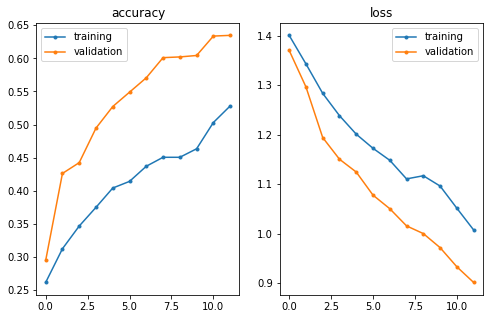

In [21]:
plotPerformance(model_trained_mobnet)

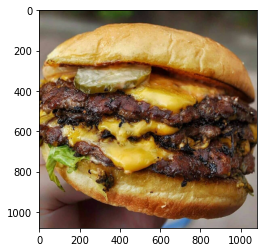

In [40]:
im = plt.imread('/content/prova0.jpg')
plt.imshow(im)

In [24]:
model_trained_mobnet

AttributeError: ignored



---


## Test zone 



---



In [26]:
model_built.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

  # training
modello = model_built.fit(x = training, validation_data = test, epochs = 10, batch_size = 128)

Epoch 1/10
34/34 [==============================] - 12s 296ms/step - loss: 0.9867 - accuracy: 0.5358 - val_loss: 0.8857 - val_accuracy: 0.6283
Epoch 2/10
34/34 [==============================] - 9s 269ms/step - loss: 0.9816 - accuracy: 0.5366 - val_loss: 0.8768 - val_accuracy: 0.6370
Epoch 3/10
34/34 [==============================] - 9s 267ms/step - loss: 0.9785 - accuracy: 0.5400 - val_loss: 0.8652 - val_accuracy: 0.6337
Epoch 4/10
34/34 [==============================] - 9s 268ms/step - loss: 0.9433 - accuracy: 0.5449 - val_loss: 0.8459 - val_accuracy: 0.6533
Epoch 5/10
34/34 [==============================] - 9s 269ms/step - loss: 0.9468 - accuracy: 0.5516 - val_loss: 0.8392 - val_accuracy: 0.6326
Epoch 6/10
34/34 [==============================] - 9s 267ms/step - loss: 0.9217 - accuracy: 0.5608 - val_loss: 0.8370 - val_accuracy: 0.6413
Epoch 7/10
34/34 [==============================] - 9s 265ms/step - loss: 0.9190 - accuracy: 0.5594 - val_loss: 0.8181 - val_accuracy: 0.6467
Epoch

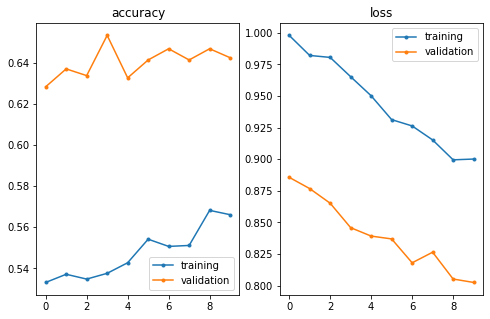

In [28]:
plotPerformance(modello)

In [49]:
im2 = skimage.transform.resize(im,(1,224,224,3))

In [50]:
im2.shape

(1, 224, 224, 3)

In [51]:
model_built.predict(im2)

array([[0.32139882, 0.27610552, 0.21353708, 0.18895859]], dtype=float32)